<a href="https://colab.research.google.com/github/ShengpeiWang/kick-with-bert/blob/master/kick_roberta_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import and shape the data
Since BERT based models tend to perform best with short input, I'm going to split up the sentences into seperate records.

In [ ]:
# local colab set up
# remember to turn the GPU option on
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/kick'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Load and wrangle the Kickstarter data


In [ ]:
# load the kickstarter dataset from my previous kickstarter project
# Data cleaning was done in the other jupyter notebooks
import pickle
with open(base_dir + "/project_data_complete.pkl", "rb") as f:
  df = pickle.load(f)

In [ ]:
df['story_tb'] = df["project_name"].map(str) + df["blurb"].map(str) +df["story"].map(str)

In [ ]:
df.columns = ['index', 'project_id_1', 'url', 'story', 'project_id', 'project_name',
       'blurb', 'goal', 'pledge', 'state', 'country', 'deadline', 'create',
       'launch', 'staff_pick', 'backers', 'usd_rate', 'creator', 'category',
       'url', 'category_name', 'category_parent', 'name_parent', 'goal_usd',
       'pledge_usd', 'percent', 'days_active', 'days_draft', 'language',
       'keep_story', 'story_tb']

In [ ]:
import numpy as np
import pandas as pd
df['l_goal'] = np.log10(df['goal_usd'] + 1)
df['l_pledge'] = np.log10(df['pledge_usd'] + 1)
df['l_percent'] = np.log10(df['percent']*100+1)
max_bin = max(df['percent']*100)+1
df['performance'] = pd.cut(df['percent']*100,
                                 bins = [0, 1, 100, 120, max_bin], 
                                 labels = ["fail", "some", "goal", "great"],
                                 right = False)
df['performance_n'] = pd.cut(df['percent']*100,
                                 bins = [0, 1, 100, 120, max_bin], 
                                 labels = [0,1,2,3],
                                 right = False)
df['performance_s'] = round(df['l_pledge'])

In [ ]:
df. groupby(['performance_s']).count()

,index,project_id_1,url,story,project_id,project_name,blurb,goal,pledge,state,country,deadline,create,launch,staff_pick,backers,usd_rate,creator,category,url,category_name,category_parent,name_parent,goal_usd,pledge_usd,percent,days_active,days_draft,language,keep_story,story_tb,l_goal,l_pledge,l_percent,performance,performance_n
performance_s,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,286,286,286,286,286,286,286,286,286,286,286,286,286,286,286,286,286,286,286,286,286,286,286,286,286,286,286,286,286,286,286,286,286,286,286,286
1.0,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145
2.0,271,271,271,271,271,271,271,271,271,271,271,271,271,271,271,271,271,271,271,271,271,271,271,271,271,271,271,271,271,271,271,271,271,271,271,271
3.0,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619
4.0,633,633,633,633,633,633,633,633,633,633,633,633,633,633,633,633,633,633,633,633,633,633,633,633,633,633,633,633,633,633,633,633,633,633,633,633
5.0,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147
6.0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6


In [ ]:
df['story_tb'][0]

"Strange Wit, an original graphic novel about Jane BowlesThe true biography of the historical figure, writer, alcoholic, lesbian, and world traveler: Jane Sydney Auer Bowles.meet jane bowles: incredible author, inspiring woman, tortured mind.jane may have been marginalized by the cultural canon, but her contemporaries considered her “one of the finest modern writers” (john ashberry), “the most important writer of prose fiction” (tennessee williams), and further, a “genius imp, [a] laughing, hilarious, tortured elf” (truman capote). jane drank more than she wrote, worried more than she worked, and had more epically disastrous love affairs than completed books. by almost any measure, jane led a fascinating life filled with literary giants and great adventure and i want to bring her story to life.sketches of jane at various ages by tyler jenkins“although unknown to the general public, the bowleses were famous among those who were famous.” – gore vidal “my only complaint against mrs. bowle

In [ ]:
# define function to split sentences 
import re
alphabets= "([A-Za-z])"
prefixes = '(mr|st|mrs|ms|dr)[.]'
suffixes = '(inc|ltd|jr|sr|co)'
starters = '(mr|mrs|ms|dr|he\\s|she\\s|it\\s|they\\s|their\\s|our\\s|we\\s|but\\s|however\\s|that\\s|this\\s|wherever)'
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"
digits = "([0-9])" 

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    text = re.sub(digits + "[.]" + digits,"\\1<prd>\\2",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

In [ ]:
split_into_sentences(df['story_tb'][1])[:10]
# looks reasonble
# I also want to filter out the really short sentences and keep only the first few for training the model. 
# Since having a strong start is critical for proposals

['The FishbowlA dark and magical film set in a brothel, an unexpected love, a strong-willed Russian madam and The Cross at its most fabulous!',
 'harnessing a whirlwind of power, intrigue and obsession across two continents from russia to australia, the fishbowl draws you into the enticing world of kings cross, the characters who are drawn to it, and the one women who dares to control it all.',
 "please help us fund this project, we can't do it without you!",
 'who are you?',
 'hi.',
 'i’m michele konrad, an independent filmmaker based in sydney, australia.',
 "i’m getting ready to make an amazing film, the story of a heroic russian madam who sets up a brothel in sydney's iconic district of sin, king's cross.",
 'the film is called the fishbowl.',
 'i’m so excited to be working with this wonderful creative team, including: paul j warren – cinematographer (the cup, milarepa) paul is one of australia’s most experienced directors of photography.',
 "in addition to his feature film and nar

In [ ]:
a = split_into_sentences(df['story_tb'][1])[:10]
[z for z in a if len(z) > 20][:5]

['The FishbowlA dark and magical film set in a brothel, an unexpected love, a strong-willed Russian madam and The Cross at its most fabulous!',
 'harnessing a whirlwind of power, intrigue and obsession across two continents from russia to australia, the fishbowl draws you into the enticing world of kings cross, the characters who are drawn to it, and the one women who dares to control it all.',
 "please help us fund this project, we can't do it without you!",
 'i’m michele konrad, an independent filmmaker based in sydney, australia.',
 "i’m getting ready to make an amazing film, the story of a heroic russian madam who sets up a brothel in sydney's iconic district of sin, king's cross."]

In [ ]:
def split_into_sentences_c(df, column_text = "story_tb", column_id = "project_id", slength = 20, snum = 5):
  ids = []
  sentences = []
  for index, row in df.iterrows():
    idd = row[column_id]
    ss_raw = split_into_sentences(row[column_text])
    ss = [z for z in ss_raw if len(z) > slength][:snum] # filter down to the first 5 sentences that aren't too short
    ids.extend([str(idd)] * len(ss))
    sentences.extend(ss)
  print(len(ids))
  dfsentence = pd.DataFrame(data = {column_id: ids, column_text: sentences})
  return dfsentence

In [ ]:
dfs = df[['project_id', 'story_tb']].copy()
dfs

,project_id,story_tb
0,498799566,"Strange Wit, an original graphic novel about J..."
1,968368451,The FishbowlA dark and magical film set in a b...
2,1760442719,Publishing Magus MagazineWe are publishing a m...
3,1526833653,Living Life TinyEducating my community about s...
4,1745759340,GP LiveRewarding you for all of the things you...
...,...,...
2102,1150142009,Nightingale HorsesHORSE SLAUGHTER:One of the u...
2103,1660539605,I Want To Be A Professional Racing DriverMy go...
2104,1781536709,The Stone Sisters: LonerStone Sisters is an ol...
2105,915338604,The Noble GuardianThe mysterious legacy brings...


In [ ]:
data_sentences = split_into_sentences_c(df = dfs.iloc[:10, :])

48


In [ ]:
data_sentences[:10]
# looks like reasonable sentences

,project_id,story_tb
0,498799566,"Strange Wit, an original graphic novel about J..."
1,498799566,"meet jane bowles: incredible author, inspiring..."
2,498799566,jane may have been marginalized by the cultura...
3,498799566,"jane drank more than she wrote, worried more t..."
4,498799566,"by almost any measure, jane led a fascinating ..."
5,968368451,The FishbowlA dark and magical film set in a b...
6,968368451,"harnessing a whirlwind of power, intrigue and ..."
7,968368451,"please help us fund this project, we can't do ..."
8,968368451,"i’m michele konrad, an independent filmmaker b..."
9,968368451,"i’m getting ready to make an amazing film, the..."


In [ ]:
data_sentences = split_into_sentences_c(df = dfs)

10370


In [ ]:
# save the sentece dataframe:
#with open(base_dir + "/project_data_sentences.pkl", "wb") as f:
#  pickle.dump(data_sentences, f)


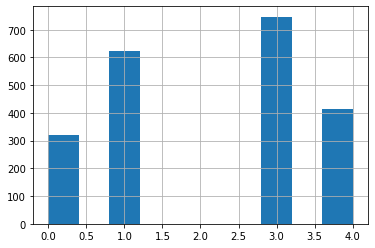

In [ ]:
df['performance_s'] = pd.cut(df['l_pledge'],
                                 bins = [0, 1, 3, 4, 7], 
                                 labels = [0,1,3,4],
                                 right = False)
df['performance_s'].hist()
# The bins aren't totally even, but close enough

In [ ]:
# train test split:
from sklearn.model_selection import train_test_split
dat_train, dat_test, _, _ = train_test_split(df[['project_id', 'l_pledge', 'performance_s']], df[['project_id', 'l_pledge', 'performance_s']], 
                                             test_size = 0.20, random_state = 61, stratify = df[['name_parent']])


In [ ]:
data_train = data_sentences.astype({'project_id': 'int64'}).merge(dat_train, how='inner', on='project_id')
data_test = data_sentences.astype({'project_id': 'int64'}).merge(dat_test, how='inner', on='project_id')
data_train.shape, data_test.shape

((8294, 4), (2076, 4))

In [ ]:
data_train.shape, data_test.shape

((8294, 4), (2076, 4))

In [ ]:
# save the sentece dataframe:
with open(base_dir + "/project_data_sentences_train.pkl", "wb") as f:
  pickle.dump(data_train, f)

with open(base_dir + "/project_data_sentences_test.pkl", "wb") as f:
  pickle.dump(data_test, f)